In [1]:
%%capture
import pandas as pd
import os, requests, json
import numpy as np
os.chdir('/Users/denis/Documents/Projects/hiv-analysis/hiv-signature-analysis')
%load_ext rpy2.ipython
%R source('/Users/denis/Documents/Projects/scripts/Support.R')
%R library(ggplot2)
%R library(reshape2);

# Gene Signature Analysis

## Overview

The purpose of this notebook is to investigate the differential expression results of cell-line derived HIV-infected data, and the effect of the batch effect removal algorithm on these genes.

## Computation

In [213]:
# Get infiles
infiles = ['f5-geneset_enrichment.dir/podocyte_cell_line-vst_corrected-differential_expression_geneset_enrichment.txt', 'f5-geneset_enrichment.dir/podocyte_cell_line-vst_corrected-differential_expression_geneset_ids.txt', 'f6-l1000cds2_analysis.dir/podocyte_cell_line-vst_corrected-differential_expression_l1000cds2_results.txt'] 

# Read data
enrichmentDataframe = pd.read_table(infiles[0])
genelistDataframe = pd.read_table(infiles[1])

# Fix timepoints
enrichmentDataframe['timepoint'] = [x.replace('h','')+'h' for x in enrichmentDataframe['timepoint']]

### Code

In [11]:
# Enrichment data
enrichmentData = {}

# Add data
for direction in ['upregulated', 'downregulated']:
    enrichmentDataframeSubset = enrichmentDataframe.loc[enrichmentDataframe['direction'] == direction, :]
    enrichmentDataframeCast = enrichmentDataframeSubset.pivot(index='term_name', columns='timepoint', values='combined_score').fillna(0).loc[:,['6h','12h','24h','48h']]
    sortedTerms = enrichmentDataframeCast.apply(sum, 1).sort_values(ascending=False).index
    enrichmentData[direction] = enrichmentDataframeCast.loc[sortedTerms, :]
    
upregulatedEnrichmentData = enrichmentData['upregulated']
downregulatedEnrichmentData = enrichmentData['downregulated']

# Enrichment data
significanceData = {}

# Add data
for direction in ['upregulated', 'downregulated']:
    enrichmentDataframeSubset = enrichmentDataframe.loc[enrichmentDataframe['direction'] == direction, :]
    enrichmentDataframeCast = enrichmentDataframeSubset.pivot(index='term_name', columns='timepoint', values='FDR').fillna(1).loc[:,['6h','12h','24h','48h']]
    sortedTerms = enrichmentDataframeCast.apply(sum, 1).sort_values(ascending=False).index
    significanceData[direction] = enrichmentDataframeCast.loc[sortedTerms, :]
    
upregulatedSignificanceData = significanceData['upregulated']
downregulatedSignificanceData = significanceData['downregulated']

In [263]:
# Read L1000CDS2 Data
signatureResultDataframe = pd.read_table(infiles[2]).drop('drugbank_id', 1)

In [265]:
%%R -i signatureResultDataframe
# Get sorted IDs
drugCounts <- sort(table(signatureResultDataframe$pubchem_id), decreasing=TRUE)

In [264]:
%%R
# Count occurrence of drugs
drugCountTimepoint <- t(table(signatureResultDataframe$timepoint, signatureResultDataframe$pubchem_id))[names(drugCounts),c('h6', 'h12', 'h24', 'h48')]

## Plots

In [197]:
%%R -i upregulatedEnrichmentData,downregulatedEnrichmentData,upregulatedSignificanceData,downregulatedSignificanceData
plot_enrichment <- function(enrichmentDataframe, significanceDataframe, direction, termName, main=NULL, mar=c(5,4,7,2)) {
    
    # Set margins
    par(mar=mar)
    
    # Fix colnames
    colnames(enrichmentDataframe) <- gsub('X', '', colnames(enrichmentDataframe))
    
    # Get plot dataframe
    barpos <- barplot(rev(as.numeric(enrichmentDataframe[termName,])),
                  names.arg=rev(colnames(enrichmentDataframe)),
                  main = main,
                  xlab = 'Enrichment Score',
                  ylab = 'Timepoint',
                  las = 2,
                  horiz = TRUE,
                  col = ifelse(direction=='upregulated', 'red3', 'navyblue'))
    
    # Add term
    mtext(gsub('(', '\n(', termName, fixed=TRUE)[[1]][1], padj=-0.2, cex=0.8)
    
    # Add text
    pvalueLabels <- paste0('q=', format.pval(rev(as.numeric(significanceDataframe[termName,])), digits=1))
    pvalueLabels <- sapply(rev(significanceDataframe[termName,]), function(x) ifelse(x <= 0.1, paste0('q=', format.pval(x, digits=1)), ''))
    text(x=0, y=barpos, labels=pvalueLabels, pos=4, offset=0.5, col='white', cex=1.2)
}

At the 6 hour timepoint, HIV-infected cells show an increased expression of genes related to *virus response*, *type I interferon signaling* and *ECM remodeling*, with a very significant increase at the 12 hour timepoint.  This is also accompanied by a decreased expression of genes involved in DNA replication-independent nucleosome assembly.

At latter timepoints (24h and 48h), we can observe a decreased expression of genes involved in *protein-kinase inhibition* and *cyclin-dependent kinase inhibitors (CKI)*, possibly indicating an increase in proliferation.

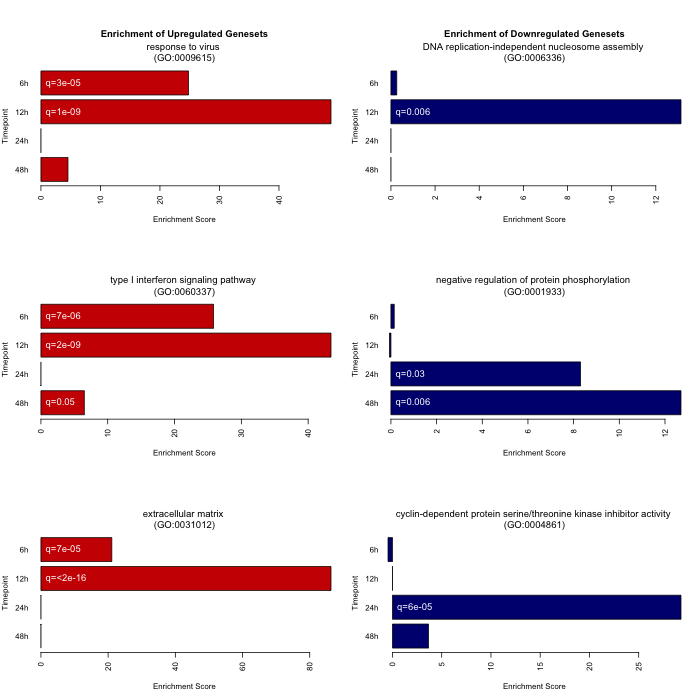

In [212]:
%%R -h 700 -w 700
par(mfrow=c(3,2))
plot_enrichment(upregulatedEnrichmentData, upregulatedSignificanceData, 'upregulated', termName='response to virus (GO:0009615)', main='Enrichment of Upregulated Genesets')
plot_enrichment(downregulatedEnrichmentData, downregulatedSignificanceData, 'downregulated', termName='DNA replication-independent nucleosome assembly (GO:0006336)', main='Enrichment of Downregulated Genesets')
plot_enrichment(upregulatedEnrichmentData, upregulatedSignificanceData, 'upregulated', termName='type I interferon signaling pathway (GO:0060337)')
plot_enrichment(downregulatedEnrichmentData, downregulatedSignificanceData, 'downregulated', termName='negative regulation of protein phosphorylation (GO:0001933)')
plot_enrichment(upregulatedEnrichmentData, upregulatedSignificanceData, 'upregulated', termName='extracellular matrix (GO:0031012)')
plot_enrichment(downregulatedEnrichmentData, downregulatedSignificanceData, 'downregulated', termName='cyclin-dependent protein serine/threonine kinase inhibitor activity (GO:0004861)')

### L1000CDS<sup>2</sup>

Below are the top recurrent drugs displayed within the top 50 most similar signatures to the gene expression signatures observed in HIV infection.

In [268]:
%%R
head(drugCountTimepoint)

          
           h6 h12 h24 h48
  11957493  2   1   0  12
  71748056  2   2   2   3
  9967941   3   3   0   0
  2900      1   1   0   3
  6197      1   2   0   2
  253602    1   1   0   1


The frames below displays PubChem information of the top 3 drugs.

In [269]:
import IPython
pubchemId = 11957493
IPython.display.HTML('<iframe src=https://pubchem.ncbi.nlm.nih.gov/compound/%(pubchemId)s width=900 height=350></iframe>' % locals())

In [272]:
import IPython
pubchemId = 71748056
IPython.display.HTML('<iframe src=https://pubchem.ncbi.nlm.nih.gov/compound/%(pubchemId)s width=900 height=350></iframe>' % locals())

In [271]:
import IPython
pubchemId = 9967941
IPython.display.HTML('<iframe src=https://pubchem.ncbi.nlm.nih.gov/compound/%(pubchemId)s width=900 height=350></iframe>' % locals())